# 학습 관련 기술들

## 매개변수 갱신

### 모험가 이야기
### 확률적 경사 하강법(SGD)

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

* SGD 클래스를 활용한 신경망 매개변수 진행

        network = TwoLayerNet(...)
        optimizer = SGD()

        for i in range(10000):
            ...
            x_batch, t_batch = get_mini_batch(...) # 미니 배치
            grads = network.gradient(x_batch, t_batch)
            params = network.params
            optimizer.update(params, grads)
            ...
* optimizer : 최적화를 행하는 자
SGD()가 그 역할을 한다.  
매개변수 갱신을 optimizer가 하고, 사용자가 매개변수와 기울기 정보를 optimizer에 입력한다.
* 최적화 담당 클래스를 분리해서 구현하면 모듈화 하기 좋다.  
optimizer = SGD()  
optimizer = Momentum() : SGD가 모멘텀으로 바뀐다.
* Lasagne 딥러닝 프레임워크 : updates.py 에 최적화 기법을 구현.

### SGD의 단점
문제에 따라 비효율적일 때가 있다.  
다음 함수의 최솟값 구하는 문제
$$f(x,y) = {1 \over 20}x^2 + y^2$$

* 함수의 그래프(왼쪽), 등고선(오른쪽)
![img](./deep_learning_images/fig_6-1.png)

* 함수의 기울기
![img](./deep_learning_images/fig_6-2.png)
y축 방향이 크고, x축 방향은 작다.  

* 주의할 점
    * 최솟값이 되는 장소는 $(x,y) = (0,0)$이지만 그림의 기울기는 대부분 원점을 가리키지 않는다.
    
* SGD 적용  
초깃값을 $(x,y) = (-7.0,2.0)$으로 지정한다.
![img](./deep_learning_images/fig_6-3.png)
최솟값인 원점까지 지그재그로 이동한다. 비효율적이다.  
심하게 굽어진 움직임을 보여준다.  
* SGD 단점
    * 비등방성(anisotropy) 함수(기울기가 달라지는 함수)에서 탐색 경로가 비효율적이다.
    * 근본 원인 : 기울어진 방향이 본래의 최솟값과 다른 방향을 가리킨다.
    
* 개선한 방법
    * 모멘텀, AdaGrad, Adam 소개

### 모멘텀
모멘텀(momentum)

In [4]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None #v : 물체의 속도
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
                params[key] += self.v[key]

모멘텀에 의한 최적화 갱신 경로
![img](./deep_learning_images/fig_6-5.png)
SGD 보다 지그재그 정도가 덜하다.  
> x축의 힘이 아주 작지만 방향이 변하지 않아서, 한 방향으로 일정하게 가속하기 때문이다.

### AdaGrad

$$\mathbf{h} \leftarrow \mathbf{h} + {\partial L \over \partial \mathbf{W}} \odot {\partial L \over \partial \mathbf{W}} \\
\mathbf{W} \leftarrow \mathbf{W} - \eta{1 \over \sqrt{\mathbf{h}}} {\partial L \over \partial \mathbf{W}}$$

In [6]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params, items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

![img](./deep_learning_images/fig_6-6.png)



### Adam
모멘텀과 AdaGrad 기법을 융합한 것이 Adam이다.
![img](./deep_learning_images/fig_6-7.png)


### 어느 갱신 방법을 사용할 것인가?

![img](./deep_learning_images/fig_6-8.png)

### MNIST 데이터셋으로 본 갱신 방법 비교

![img](./deep_learning_images/fig_6-9.png)

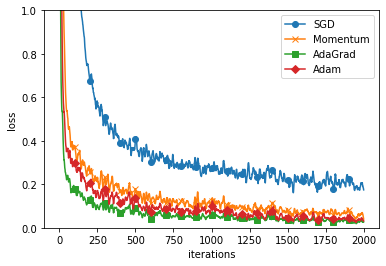

In [34]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
       # print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            #print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 가중치의 초깃값
### 초깃값을 0으로 하면?
가중치 감소(weight decay)
### 은닉층의 활성화값 분포

In [47]:
# 은닉층의 활성화 함수의 출력 데이터 분포 : 중요한 정보 제공
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+ np.exp(-x)) # 시그모이드

x = np.random.randn(1000, 100) # 1000개 데이터
node_num = 100 # 은닉층별 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} #활성화값 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

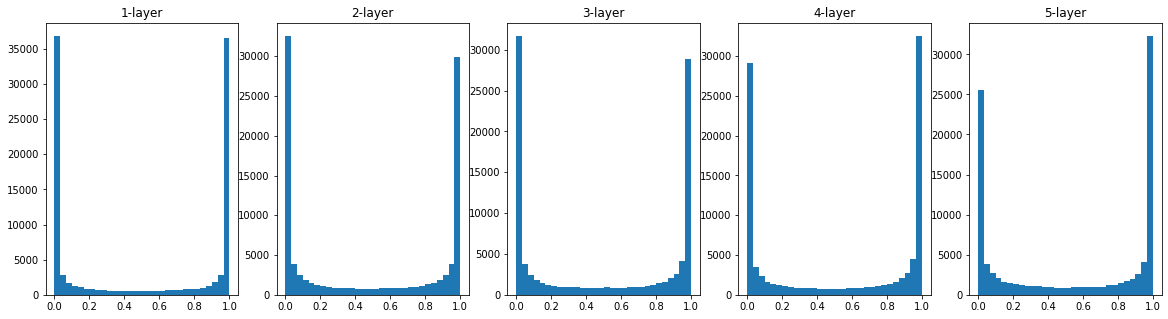

In [48]:
# 히스토그램 그리기
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

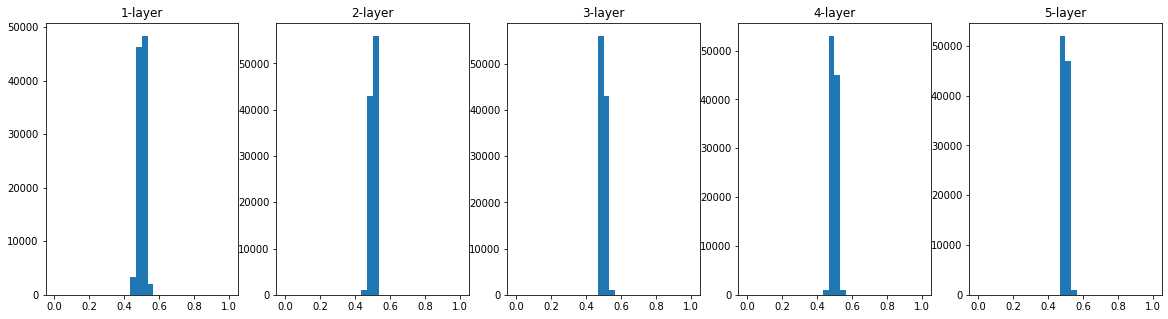

In [49]:
# 표준편차 0.01로 변경
plt.figure(figsize=(20,5))
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]    
        
    w = np.random.randn(node_num, node_num) * 0.01 #표준편차가 1 -> 0.01로 변경
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

0.5 부근에 집중되어, 0과 1로 치우치진 않아서 기울기 소실(gradient vanishing) 문제는 발생하지 않았다.  
다만, 활성화 값이 집중되다(=치우치다)는 것은 **표현력을 제한**한다는 점에서 문제가 된다.

* Xavier 초깃값  
일반적인 딥러닝 프레임워크에서 표준 이용하는 가중치 초깃값  
* 앞 계층의 노드가 n 개이면, 표준편차는 $1 \over \sqrt{n}$ 인 분포를 사용하라  
![img](./deep_learning_images/fig_6-12.png)

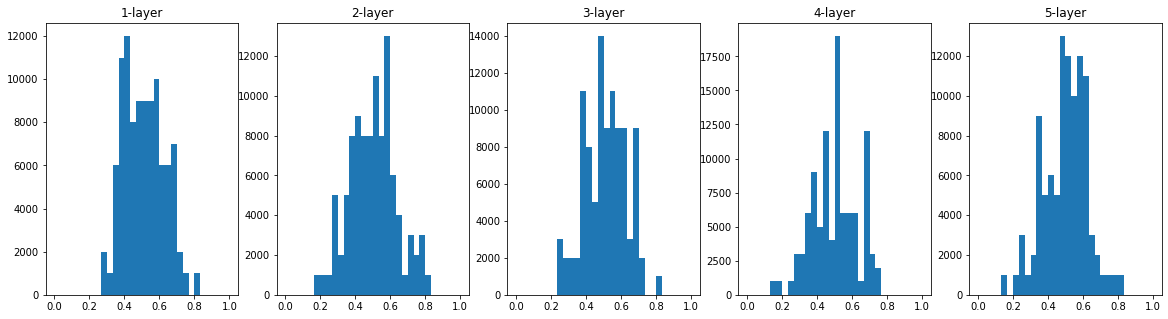

In [50]:
# 표준편차 0.01로 변경
plt.figure(figsize=(20,5))
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #표준편차가 1 -> 1/n로 변경
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()



Xavier 초깃값 사용시  
* 층이 깊어지면서 형태가 다소 일그러짐
* 앞보다 확실히 넓게 분포가 된다. 적당히 퍼진다.  
= 표현력이 제한받지 않는다.  
+ 학습이 효율적이다.

### ReLU를 사용할 때의 가중치 초깃값
* He 초깃값  
앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{2 \over n}$인 정규분포를 사용한다.  
* std = 0.01, Xavier, He 비교
![img](./deep_learning_images/fig_6-14.png)
* ReLU 활성화 함수는 He 초깃값
* sigmoid, tanh(S자 모양 곡선) 활성화 함수는 Xavier 초깃값

### MNIST 데이터셋으로 본 가중치 초깃값 비교

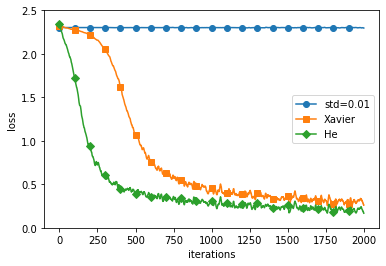

In [51]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        #print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            #print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 배치 정규화
배치 정규화(Batch Normalization)
### 배치 정규화 알고리즘
* 주목받는 이유
    * 학습 속도 개선
    * 초깃값 크게 의존하지 않음
    * 오버피팅 억제(드롭아웃 필요성 감소)
    
$$\mu_B \leftarrow {1 \over m} \sum_{i=1}^m x_i \\
\sigma_B^2 \leftarrow \sum_{i=1}^m(x_i - \mu_B)^2 \\
\hat{x}_i \leftarrow {x_i - \mu_B \over \sqrt{\sigma_B^2 + \epsilon}}$$

* 배치 정규화에 의한 데이터 고유 확대(scale), 이동(shift) 변환  
$$ y_i \leftarrow \gamma\hat{x}_i + \beta$$
$\gamma$ 확대(scale), $\beta$ 이동(shift)  
* 배치 정규화의 계산 그래프
![img](./deep_learning_images/fig_6-17.png)



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


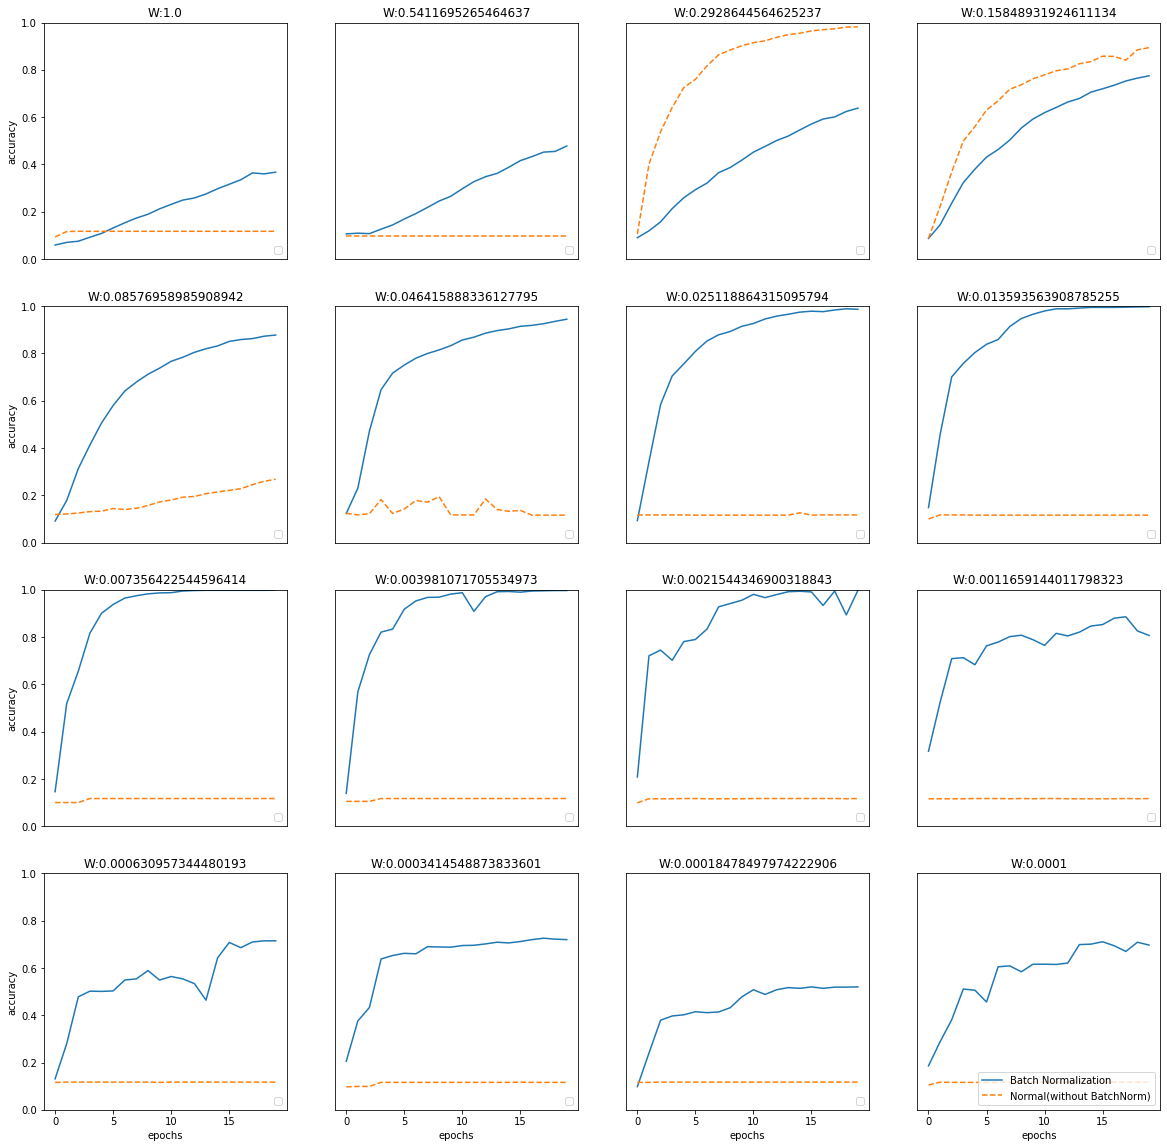

In [53]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam
import warnings
warnings.filterwarnings("ignore")
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

plt.figure(figsize=(20,20))
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    #print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

배치 정규화를 사용한 경우 실선, 배치 정규화 사용하지 않은 경우 점선 : 가중치 초깃값의 표준편차는 각 그래프 위에 표기했다.
![img](./deep_learning_images/fig_6-19.png)

* 거의 모든 경우, 배치 정규화 사용시 학습 진도가 빠르다.  
* 배치 정규화 미사용시, 가중치 초깃값이 잘 분포되어 있지 않으면 학습이 진행되지 않는다.


## 바른 학습을 위해
오버피팅(overfitting)  
### 오버피팅
* 발생하는 경우
    * 매개변수가 많고 표현력이 높은 모델(복잡한 모델)
    * 훈련 데이터가 적다

In [25]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)

# 오버피팅을 재현하고자 학습 데이터 수를 줄인다.
x_train = x_train[:300]
t_train = t_train[:300]

In [26]:
#훈련 수행
network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100, 100, 100, 100, 100], output_size = 10)
optimizer = SGD(lr=0.01) #학습률이 0.01 SGD
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt +=1
        if epoch_cnt >= max_epochs:
            break

* train_acc_list, test_acc_list : 에폭 단위의 정확도를 저장한다.
![img](./deep_learning_images/fig_6-20.png)
* 훈련 데이터에만 적응(fitting)하여 범용 데이터에 제대로 대응하지 못한다.

### 가중치 감소
가중치 감소(weight decay)  
![img](./deep_learning_images/fig_6-21.png)
* 앞에 실험 결과와 비교하여 오버피팅이 억제됐다

### 드롭아웃
드롭아웃(Dropout)
![img](./deep_learning_images/fig_6-22.png)
[더 효율적인 구현](http://chainer.org/)

In [27]:
#드롭아웃
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

* 훈련 시 순전파에서 self.mask 삭제할 뉴런을 False로 표기
* self.mask  
x와 형상이 같은 배열 무작위 생성  
dropout_ratio보다 큰 원소만 True로 설정  
* 훈련시 역전파는 ReLU와 동일

* 드롭아웃 여부 비교(dropout_ratio = 0.15)
![img](./deep_learning_images/fig_6-23.png)
* 앙상블 학습(ensemble learning)

## 적절한 하이퍼파라미터 값 찾기
### 검증 데이터

In [31]:
from common.util import shuffle_dataset
# 훈련 데이터 중 20%를 검증 데이터로 분리
(x_train, t_train), (x_test, t_test) = load_mnist()

# 뒤섞기
x_train, t_train = shuffle_dataset(x_train, t_train)

#20% split
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 하이퍼파라미터 최적화
* 하이퍼파라미터 값의 범위 설정
* 설정된 범위에서 하이퍼파라미터 값 무작위 추출
* 1단계에서 샘플링한 하이퍼파라미터 값으로 학습하고, 검증 데이터로 정확도 평가(에폭은 작게 설정)
* 1단계와 2단계 특정 횟수(100회 등) 반복하고, 그 정확도 결과를 보고 하이퍼파라미터 범위 좁히기

### 하이퍼파라미터 최적화 구현하기
* 하이퍼파라미터의 무작위 추출 코드

        weight_decay = 10 ** np,.random.uniform(-8, -4)
        lr = 10 ** np.random.uniform(-6, -2)
![img](./deep_learning_images/fig_6-24.png)

    Best-1(val acc:0.84) | lr:0.006633674228511619, weight decay:1.6955036147903627e-07
    Best-2(val acc:0.8) | lr:0.006846041344311443, weight decay:8.186736507254628e-07
    Best-3(val acc:0.79) | lr:0.008049488230927838, weight decay:2.8666465700377217e-06
    Best-4(val acc:0.79) | lr:0.006578832253086749, weight decay:3.6368962596379066e-05
    Best-5(val acc:0.77) | lr:0.0077532149175545875, weight decay:1.913940595015841e-05
* 학습이 잘 진행될 때 하이퍼 파라미터
    * 학습률 : 0.001 ~ 0.01
    * 가중치 감소 계수 : $10^{-8}$ ~ $10^{-6}$  

## 정리
* 매개변수 갱신 방법 : 확률적 경사 하강법(SGD) 외에 모멘텀, AdaGrad, Adam 등이 있다.
* 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
* 가중치의 초깃값으로는 'Xavier 초깃값'과 'He 초깃값'이 효과적이다.
* 배치 정규화를 이용하면 학습을 빠르게 진행 및 초깃값 영향이 적어진다.
* 오버피팅 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
* 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 _범위를 점차 좁히면서_ 하는 것이 효과적이다.